In [ ]:
!pip install lazypredict transformers

In [ ]:
import os
import sys
import shutil
import tempfile
import urllib.request
import zipfile
from sklearn.metrics import log_loss, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

TASKS = ["CoLA", "SST", "RTE"]
TASK2PATH = {"CoLA":'https://dl.fbaipublicfiles.com/glue/data/CoLA.zip',
             "SST":'https://dl.fbaipublicfiles.com/glue/data/SST-2.zip',
             "RTE":'https://dl.fbaipublicfiles.com/glue/data/RTE.zip'}

def download_and_extract(task, data_dir):
    print("Downloading and extracting %s..." % task)
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print("\tCompleted!")
    

def get_tasks(task_names):
    if "all" in task_names:
        tasks = TASKS
    else:
        tasks = []
        for task_name in task_names:
            assert task_name in TASKS, "Task %s not found!" % task_name
            tasks.append(task_name)
    return tasks

def main():
    tasks = get_tasks('all')

    for task in tasks:
      download_and_extract(task, '/content/data')

main()

	Completed!
	Completed!
	Completed!


In [ ]:
def eval(y_true, y_pred):
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

# **No balancing techniques**

Here we explore different options for classifiers for CoLA dataset

This part is dedicated to CoLA classifier withouy balancing dataset.

In [ ]:
## CoLA
import pandas as pd

data_pth = '/content/data'
TASKS = ["CoLA", "SST-2", "RTE"]

colnames_train = ['id', 'index', 'field_1', 'sentence']
colnames_test = ['index', 'sentence']
train_data = pd.read_table(os.path.join(data_pth, TASKS[0], 'train.tsv'), names=colnames_train, header=None)
test_data = pd.read_table(os.path.join(data_pth, TASKS[0], 'dev.tsv'), names=colnames_train, header=None)

In [ ]:
test_data

,id,index,field_1,sentence
0,gj04,1,NaN,The sailors rode the breeze clear of the rocks.
1,gj04,1,NaN,The weights made the rope stretch over the pul...
2,gj04,1,NaN,The mechanical doll wriggled itself loose.
3,cj99,1,NaN,"If you had eaten more, you would want less."
4,cj99,0,*,"As you eat the most, you want the least."
...,...,...,...,...
1038,w_80,1,NaN,John considers Bill silly.
1039,w_80,1,NaN,John considers Bill to be silly.
1040,w_80,0,*,John bought a dog for himself to play with.
1041,w_80,1,NaN,John arranged for himself to get the prize.


In [ ]:
x_train = train_data.loc[:,'sentence']
y_train = train_data.loc[:,'index']
x_test = test_data.loc[:,'sentence']
y_test = test_data.loc[:,'index']

## **Model representation - BERT**

Different representation approaches is used, first of them is BERT with attention mask for better data representation.

In [ ]:
import time
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

stop_words = set(stopwords.words('english'))
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

def sent_preprocess(sentence):
  word_tokens = word_tokenize(sentence)
  filtered_sentence = [w.lower() for w in word_tokens if w not in stop_words]
  
  tokens = {'input_ids': [], 'attention_mask': []}

  new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                                      truncation=True, padding='max_length',
                                      return_tensors='pt')
  tokens['input_ids'].append(new_tokens['input_ids'][0])
  tokens['attention_mask'].append(new_tokens['attention_mask'][0])

  tokens['input_ids'] = torch.stack(tokens['input_ids'])
  tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

  outputs = model(**tokens)
  embeddings = outputs.last_hidden_state

  attention_mask = tokens['attention_mask']
  mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
  masked_embeddings = embeddings * mask
  summed = torch.sum(masked_embeddings, 1)
  summed_mask = torch.clamp(mask.sum(1), min=1e-9)
  mean_pooled = summed / summed_mask

  mean_pooled = mean_pooled.detach().numpy()

  return mean_pooled

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [ ]:
import tqdm

x_train_preprocessed = [sent_preprocess(sent) for sent in tqdm.tqdm(x_train)]
x_test_preprocessed = [sent_preprocess(sent) for sent in tqdm.tqdm(x_test)]

100%|██████████| 1043/1043 [08:11<00:00,  2.12it/s]


In [ ]:
## data is saved for optimization purposes - in order to save time calculating BERT representation of data

x_train_preprocessed_bert = x_train_preprocessed
x_test_preprocessed_bert = x_test_preprocessed

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np
import pandas as pd

size = np.array(x_train_preprocessed).shape[0]
vector_size = 768

## This part is to save data into csv file

df_train = pd.DataFrame(np.array(x_train_preprocessed).reshape([size,vector_size]))
df_test = pd.DataFrame(np.array(x_test_preprocessed).reshape([np.array(x_test_preprocessed).shape[0],vector_size]))

df_train.to_csv('df_train_CoLA.csv')
df_test.to_csv('df_test_CoLA.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
## Split into valid and train sets

x_valid_preprocessed = x_train_preprocessed[7501:size]
x_train_preprocessed = x_train_preprocessed[0:7500]

y_valid = y_train[7501:size]
y_train = y_train[0:7500]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

1050
7500
1050
7500


### **General Classifiers**

There is an application of most popular and wide-spread classifiers for current representation

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)

print(models)

100%|██████████| 29/29 [08:08<00:00, 16.86s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LogisticRegression                 0.71               0.65     0.65      0.71   
RidgeClassifierCV                  0.72               0.64     0.64      0.72   
RidgeClassifier                    0.71               0.63     0.63      0.71   
LinearDiscriminantAnalysis         0.70               0.63     0.63      0.70   
SGDClassifier                      0.68               0.62     0.62      0.69   
NuSVC                              0.73               0.61     0.61      0.70   
LinearSVC                          0.66               0.60     0.60      0.66   
BernoulliNB                        0.58               0.57     0.57      0.60   
NearestCentroid                    0.54               0.57     0.57      0.56   
GaussianNB                         0.56               0.57     0.57      0.58   
PassiveAggressiveClassifier 

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['RidgeClassifierCV'].predict(np.array(x_test_preprocessed).reshape([x_test.shape[0],vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

753 1043


BERT, best general classifier, no balancing techniques
F-measure or f1-score:  0.8145780051150895
Log loss:  9.603461046591292
AUC:  0.6218717964180185
Classification Report:
              precision    recall  f1-score   support

           1     0.7556    0.8835    0.8146       721
           0     0.5800    0.3602    0.4444       322

    accuracy                         0.7220      1043
   macro avg     0.6678    0.6219    0.6295      1043
weighted avg     0.7014    0.7220    0.7003      1043



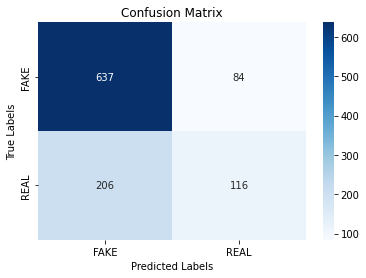

In [ ]:
# model evaluation

import matplotlib.pyplot as plt
import seaborn as sns

print("BERT, best general classifier, no balancing techniques")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

### **LSTM classifier**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed), y_train, validation_data=(np.array(x_valid_preprocessed), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
59/59 [==============================] - 19s 217ms/step - loss: 0.6048 - val_loss: 0.5818
Epoch 2/50
59/59 [==============================] - 12s 197ms/step - loss: 0.5586 - val_loss: 0.5848
Epoch 3/50
59/59 [==============================] - 12s 199ms/step - loss: 0.5342 - val_loss: 0.5685
Epoch 4/50
59/59 [==============================] - 12s 198ms/step - loss: 0.4944 - val_loss: 0.5681
Epoch 5/50
59/59 [==============================] - 12s 200ms/step - loss: 0.4601 - val_loss: 0.5729
Epoch 6/50
59/59 [==============================] - 12s 199ms/step - loss: 0.4171 - val_loss: 0.6332
Epoch 7/50
59/59 [==============================] - 12s 198ms/step - loss: 0.3905 - val_loss: 0.6378
Epoch 8/50
59/59 [==============================] - 12s 198ms/step - loss: 0.3605 - val_loss: 0.6574
Epoch 9/50
59/59 [==============================] - 12s 199ms/step - loss: 0.3257 - val_loss: 0.6605
Epoch 10/50
59/59 [==============================] - 12s 198ms/step - loss: 0.2929 - val_lo

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

721 1043


BERT, LSTM, no balancing techniques
F-measure or f1-score:  0.8174603174603174
Log loss:  0.7572909342710693
Log loss:  10.663224803004567
AUC:  0.6606098327891731
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.6913    1.0000    0.8175       721
           0     0.0000    0.0000    0.0000       322

    accuracy                         0.6913      1043
   macro avg     0.3456    0.5000    0.4087      1043
weighted avg     0.4779    0.6913    0.5651      1043



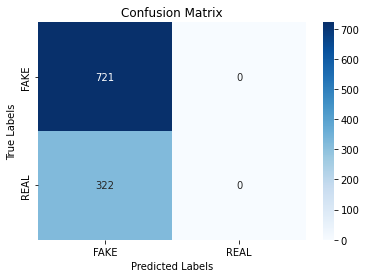

In [ ]:
# model evaluation

print("BERT, LSTM, no balancing techniques")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

## **Doc2Vec**

Application of the second representation approach.

In [ ]:
!pip install --upgrade numpy

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def sent_tokenize(sents):
  tokenized_sent = []
  for s in sents:
    word_tokens = word_tokenize(s.lower())
    filtered_sentence = [w for w in word_tokens if w not in stop_words]
    tokenized_sent.append(filtered_sentence)
  return [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]

tagged_train_sent = sent_tokenize(x_train)
tagged_test_sent = sent_tokenize(x_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tagged_train_sent

In [ ]:
vector_size = 100

model_doc2vec = Doc2Vec(tagged_train_sent+tagged_test_sent, vector_size = vector_size, window = 4, min_count = 1, epochs = 100)

In [ ]:
x_train = train_data.loc[:,'sentence']
y_train = train_data.loc[:,'index']
x_test = test_data.loc[:,'sentence']
y_test = test_data.loc[:,'index']

In [ ]:
import tqdm

x_train_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_train)]
x_test_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_test)]

x_train_preprocessed_doc2vec = x_train_preprocessed
x_test_preprocessed_doc2vec = x_test_preprocessed

100%|██████████| 1043/1043 [00:05<00:00, 193.14it/s]


In [ ]:
import numpy as np

np.array(x_train_preprocessed).shape

(8551, 100)

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np
import pandas as pd

size = np.array(x_train_preprocessed).shape[0]

df_train = pd.DataFrame(np.array(x_train_preprocessed).reshape([size,vector_size]))
df_test = pd.DataFrame(np.array(x_test_preprocessed).reshape([np.array(x_test_preprocessed).shape[0],vector_size]))

df_train.to_csv('df_train_doc2vec_100_CoLA.csv')
df_test.to_csv('df_test_doc2vec_100_CoLA.csv')

In [ ]:
x_valid_preprocessed = x_train_preprocessed[7501:size]
x_train_preprocessed = x_train_preprocessed[0:7500]

y_valid = y_train[7501:size]
y_train = y_train[0:7500]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

### **General classifier**

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)

print(models)

100%|██████████| 29/29 [01:20<00:00,  2.78s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
QuadraticDiscriminantAnalysis      0.50               0.56     0.56      0.51   
GaussianNB                         0.48               0.55     0.55      0.49   
ExtraTreeClassifier                0.58               0.51     0.51      0.59   
KNeighborsClassifier               0.65               0.51     0.51      0.62   
DecisionTreeClassifier             0.59               0.51     0.51      0.60   
NuSVC                              0.69               0.51     0.51      0.62   
XGBClassifier                      0.67               0.51     0.51      0.62   
PassiveAggressiveClassifier        0.51               0.51     0.51      0.54   
Perceptron                         0.58               0.51     0.51      0.59   
BaggingClassifier                  0.64               0.51     0.51      0.61   
ExtraTreesClassifier        

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['QuadraticDiscriminantAnalysis'].predict(np.array(x_test_preprocessed).reshape([x_test.shape[0],vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

556 1043


Doc2vec, best general classifier, no balancing techniques
F-measure or f1-score:  0.597187758478081
Log loss:  16.12702363681221
AUC:  0.5531417716939034
Classification Report:
              precision    recall  f1-score   support

           1     0.7398    0.5007    0.5972       721
           0     0.3514    0.6056    0.4447       322

    accuracy                         0.5331      1043
   macro avg     0.5456    0.5531    0.5209      1043
weighted avg     0.6198    0.5331    0.5501      1043



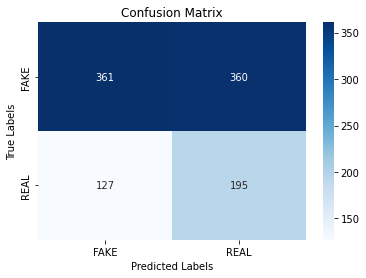

In [ ]:
# model evaluation

print("Doc2vec, best general classifier, no balancing techniques")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

### **LSTM classifier**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
59/59 [==============================] - 16s 151ms/step - loss: 0.6171 - val_loss: 0.6189
Epoch 2/50
59/59 [==============================] - 8s 133ms/step - loss: 0.6043 - val_loss: 0.6108
Epoch 3/50
59/59 [==============================] - 8s 133ms/step - loss: 0.6006 - val_loss: 0.6054
Epoch 4/50
59/59 [==============================] - 8s 133ms/step - loss: 0.5983 - val_loss: 0.6076
Epoch 5/50
59/59 [==============================] - 8s 133ms/step - loss: 0.5973 - val_loss: 0.6075
Epoch 6/50
59/59 [==============================] - 8s 134ms/step - loss: 0.5964 - val_loss: 0.6064
Epoch 7/50
59/59 [==============================] - 8s 133ms/step - loss: 0.5942 - val_loss: 0.6050
Epoch 8/50
59/59 [==============================] - 8s 133ms/step - loss: 0.5928 - val_loss: 0.6082
Epoch 9/50
59/59 [==============================] - 8s 133ms/step - loss: 0.5905 - val_loss: 0.6064
Epoch 10/50
59/59 [==============================] - 8s 134ms/step - loss: 0.5877 - val_loss: 0.610

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

721 1043


Doc2Vec, LSTM, no balancing techniques
F-measure or f1-score:  0.8174603174603174
Log loss:  0.6203679926782733
Log loss:  10.663224803004567
AUC:  0.5881754981435376
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.6913    1.0000    0.8175       721
           0     0.0000    0.0000    0.0000       322

    accuracy                         0.6913      1043
   macro avg     0.3456    0.5000    0.4087      1043
weighted avg     0.4779    0.6913    0.5651      1043



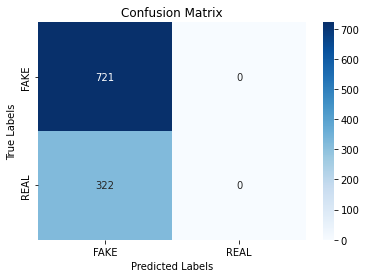

In [ ]:
# model evaluation

print("Doc2Vec, LSTM, no balancing techniques")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

# **Undersampling**

Here we apply undersampling techique in order to assess the contribution of it on classifier performance

In [ ]:
## CoLA
import pandas as pd

data_pth = '/content/data'
TASKS = ["CoLA", "SST-2", "RTE"]

colnames_train = ['id', 'index', 'field_1', 'sentence']
colnames_test = ['index', 'sentence']
train_data = pd.read_table(os.path.join(data_pth, TASKS[0], 'train.tsv'), names=colnames_train, header=None)
test_data = pd.read_table(os.path.join(data_pth, TASKS[0], 'dev.tsv'), names=colnames_train, header=None)

In [ ]:
x_train = train_data.loc[:,'sentence']
y_train = train_data.loc[:,'index']
x_test = test_data.loc[:,'sentence']
y_test = test_data.loc[:,'index']

## **BERT**

In [ ]:
import time
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

stop_words = set(stopwords.words('english'))
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

def sent_preprocess(sentence):
  word_tokens = word_tokenize(sentence)
  filtered_sentence = [w.lower() for w in word_tokens if w not in stop_words]
  
  tokens = {'input_ids': [], 'attention_mask': []}

  new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                                      truncation=True, padding='max_length',
                                      return_tensors='pt')
  tokens['input_ids'].append(new_tokens['input_ids'][0])
  tokens['attention_mask'].append(new_tokens['attention_mask'][0])

  tokens['input_ids'] = torch.stack(tokens['input_ids'])
  tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

  outputs = model(**tokens)
  embeddings = outputs.last_hidden_state

  attention_mask = tokens['attention_mask']
  mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
  masked_embeddings = embeddings * mask
  summed = torch.sum(masked_embeddings, 1)
  summed_mask = torch.clamp(mask.sum(1), min=1e-9)
  mean_pooled = summed / summed_mask

  mean_pooled = mean_pooled.detach().numpy()

  return mean_pooled

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import tqdm

if x_test_preprocessed_bert and x_train_preprocessed_bert:
  x_train_preprocessed = x_train_preprocessed_bert
  x_test_preprocessed = x_test_preprocessed_bert
else:
  x_train_preprocessed = [sent_preprocess(sent) for sent in tqdm.tqdm(x_train)]
  x_test_preprocessed = [sent_preprocess(sent) for sent in tqdm.tqdm(x_test)]

In [ ]:
from imblearn.under_sampling import NearMiss
nr = NearMiss()

vector_size = 768

x_train_preprocessed, y_train = nr.fit_resample(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed), vector_size]), y_train)

In [ ]:
x_train_preprocessed = x_train_preprocessed.reshape([len(x_train_preprocessed), 1,  vector_size])

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np
import pandas as pd

size = np.array(x_train_preprocessed).shape[0]
vector_size = 768

df_train = pd.DataFrame(np.array(x_train_preprocessed).reshape([size,vector_size]))
df_test = pd.DataFrame(np.array(x_test_preprocessed).reshape([np.array(x_test_preprocessed).shape[0],vector_size]))

df_train.to_csv('df_train_CoLA_under.csv')
df_test.to_csv('df_test_CoLA_under.csv')

In [ ]:
size

5056

In [ ]:
x_valid_preprocessed = x_train_preprocessed[4701:size]
x_train_preprocessed = x_train_preprocessed[0:4700]

y_valid = y_train[4701:size]
y_train = y_train[0:4700]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

### **General Classifiers**

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)

print(models)

100%|██████████| 29/29 [04:26<00:00,  9.18s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LinearDiscriminantAnalysis         0.62               0.62    None      0.77   
RidgeClassifier                    0.61               0.61    None      0.76   
NuSVC                              0.61               0.61    None      0.75   
RidgeClassifierCV                  0.61               0.61    None      0.75   
Perceptron                         0.60               0.60    None      0.75   
LogisticRegression                 0.59               0.59    None      0.74   
PassiveAggressiveClassifier        0.58               0.58    None      0.74   
SGDClassifier                      0.57               0.57    None      0.73   
KNeighborsClassifier               0.57               0.57    None      0.73   
LinearSVC                          0.54               0.54    None      0.70   
DecisionTreeClassifier             0.51 

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['LinearDiscriminantAnalysis'].predict(np.array(x_test_preprocessed).reshape([x_test.shape[0],vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

613 1043


BERT, best general classifier, undersampling
F-measure or f1-score:  0.6537842190016102
Log loss:  14.239468651501502
AUC:  0.6029819694868237
Classification Report:
              precision    recall  f1-score   support

           1     0.7793    0.5631    0.6538       721
           0     0.3966    0.6429    0.4905       322

    accuracy                         0.5877      1043
   macro avg     0.5879    0.6030    0.5722      1043
weighted avg     0.6611    0.5877    0.6034      1043



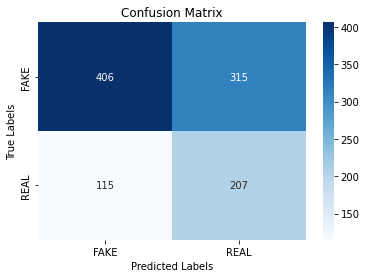

In [ ]:
# model evaluation

print("BERT, best general classifier, undersampling")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

### **LSTM classifier**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed), y_train, validation_data=(np.array(x_valid_preprocessed), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
37/37 [==============================] - 18s 319ms/step - loss: 0.6825 - val_loss: 0.8385
Epoch 2/50
37/37 [==============================] - 10s 273ms/step - loss: 0.6293 - val_loss: 0.8339
Epoch 3/50
37/37 [==============================] - 7s 191ms/step - loss: 0.6112 - val_loss: 0.7991
Epoch 4/50
37/37 [==============================] - 7s 189ms/step - loss: 0.5936 - val_loss: 0.9057
Epoch 5/50
37/37 [==============================] - 7s 189ms/step - loss: 0.5602 - val_loss: 0.8522
Epoch 6/50
37/37 [==============================] - 7s 190ms/step - loss: 0.5395 - val_loss: 0.8150
Epoch 7/50
37/37 [==============================] - 7s 190ms/step - loss: 0.5268 - val_loss: 0.8907
Epoch 8/50
37/37 [==============================] - 7s 189ms/step - loss: 0.4909 - val_loss: 0.6020
Epoch 9/50
37/37 [==============================] - 7s 190ms/step - loss: 0.4762 - val_loss: 1.0826
Epoch 10/50
37/37 [==============================] - 7s 189ms/step - loss: 0.4514 - val_loss: 0.85

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

721 1043


BERT, LSTM, undersampling
F-measure or f1-score:  0.8174603174603174
Log loss:  1.2503484568425083
Log loss:  10.663224803004567
AUC:  0.6281626622789259
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.6913    1.0000    0.8175       721
           0     0.0000    0.0000    0.0000       322

    accuracy                         0.6913      1043
   macro avg     0.3456    0.5000    0.4087      1043
weighted avg     0.4779    0.6913    0.5651      1043



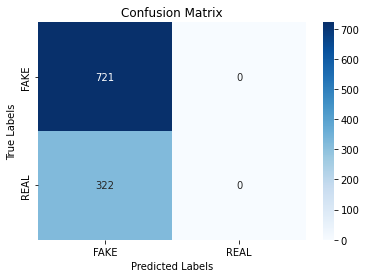

In [ ]:
# model evaluation

print("BERT, LSTM, undersampling")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

## **Doc2Vec**

In [ ]:
!pip install --upgrade numpy

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def sent_tokenize(sents):
  tokenized_sent = []
  for s in sents:
    word_tokens = word_tokenize(s.lower())
    filtered_sentence = [w for w in word_tokens if w not in stop_words]
    tokenized_sent.append(filtered_sentence)
  return [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]

tagged_train_sent = sent_tokenize(x_train)
tagged_test_sent = sent_tokenize(x_test)

In [ ]:
tagged_train_sent

In [ ]:
vector_size = 100

model_doc2vec = Doc2Vec(tagged_train_sent+tagged_test_sent, vector_size = vector_size, window = 4, min_count = 1, epochs = 100)

In [ ]:
import tqdm

if x_test_preprocessed_doc2vec and x_train_preprocessed_doc2vec:
  x_test_preprocessed = x_test_preprocessed_doc2vec
  x_train_preprocessed = x_train_preprocessed_doc2vec
else:
  x_train_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_train)]
  x_test_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_test)]

In [ ]:
x_train = train_data.loc[:,'sentence']
y_train = train_data.loc[:,'index']
x_test = test_data.loc[:,'sentence']
y_test = test_data.loc[:,'index']

In [ ]:
from imblearn.under_sampling import NearMiss
nr = NearMiss()
import numpy as np

x_train_preprocessed, y_train = nr.fit_resample(np.array(x_train_preprocessed), y_train)

In [ ]:
import numpy as np

x_train_preprocessed.shape

(5056, 100)

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np
import pandas as pd

size = np.array(x_train_preprocessed).shape[0]
vector_size = 100

df_train = pd.DataFrame(np.array(x_train_preprocessed).reshape([size,vector_size]))
df_test = pd.DataFrame(np.array(x_test_preprocessed).reshape([np.array(x_test_preprocessed).shape[0],vector_size]))

df_train.to_csv('df_train_doc2vec_100_CoLA_under.csv')
df_test.to_csv('df_test_doc2vec_100_CoLA_under.csv')

In [ ]:
print(x_train_preprocessed.shape)

(5056, 100)


In [ ]:
x_valid_preprocessed = x_train_preprocessed[4701:size]
x_train_preprocessed = x_train_preprocessed[0:4700]

y_valid = y_train[4701:size]
y_train = y_train[0:4700]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

355
4700
355
4700


### **General classifier**

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)

print(models)

100%|██████████| 29/29 [00:48<00:00,  1.66s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
KNeighborsClassifier               0.68               0.68    None      0.81   
PassiveAggressiveClassifier        0.65               0.65    None      0.79   
NearestCentroid                    0.58               0.58    None      0.73   
Perceptron                         0.48               0.48    None      0.65   
DummyClassifier                    0.46               0.46    None      0.63   
BernoulliNB                        0.44               0.44    None      0.61   
SGDClassifier                      0.44               0.44    None      0.61   
GaussianNB                         0.43               0.43    None      0.60   
LinearSVC                          0.41               0.41    None      0.58   
ExtraTreeClassifier                0.40               0.40    None      0.57   
NuSVC                              0.40 

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['PassiveAggressiveClassifier'].predict(np.array(x_test_preprocessed).reshape([x_test.shape[0],vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

545 1043


Doc2vec, best general classifier, undersampling
F-measure or f1-score:  0.6244343891402715
Log loss:  16.491335923082158
AUC:  0.49051739733461974
Classification Report:
              precision    recall  f1-score   support

           1     0.6843    0.5742    0.6244       721
           0     0.2991    0.4068    0.3447       322

    accuracy                         0.5225      1043
   macro avg     0.4917    0.4905    0.4846      1043
weighted avg     0.5654    0.5225    0.5381      1043



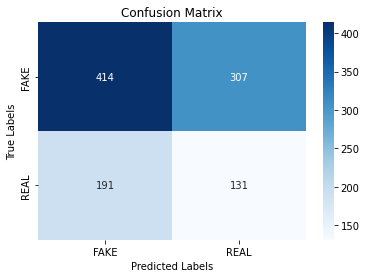

In [ ]:
# model evaluation

print("Doc2vec, best general classifier, undersampling")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

### **LSTM classifier**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
37/37 [==============================] - 19s 274ms/step - loss: 0.6866 - val_loss: 0.7435
Epoch 2/50
37/37 [==============================] - 5s 133ms/step - loss: 0.6715 - val_loss: 0.7306
Epoch 3/50
37/37 [==============================] - 5s 132ms/step - loss: 0.6657 - val_loss: 0.7010
Epoch 4/50
37/37 [==============================] - 5s 133ms/step - loss: 0.6600 - val_loss: 0.8503
Epoch 5/50
37/37 [==============================] - 5s 132ms/step - loss: 0.6501 - val_loss: 0.7445
Epoch 6/50
37/37 [==============================] - 6s 154ms/step - loss: 0.6406 - val_loss: 0.7361
Epoch 7/50
37/37 [==============================] - 5s 132ms/step - loss: 0.6242 - val_loss: 0.8584
Epoch 8/50
37/37 [==============================] - 5s 133ms/step - loss: 0.6061 - val_loss: 0.8418
Epoch 9/50
37/37 [==============================] - 5s 131ms/step - loss: 0.5836 - val_loss: 0.9304
Epoch 10/50
37/37 [==============================] - 5s 134ms/step - loss: 0.5654 - val_loss: 0.828

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

721 1043


Doc2Vec, LSTM, undersampling
F-measure or f1-score:  0.8174603174603174
Log loss:  1.406718177981876
Log loss:  10.663224803004567
AUC:  0.4690474754697151
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.6913    1.0000    0.8175       721
           0     0.0000    0.0000    0.0000       322

    accuracy                         0.6913      1043
   macro avg     0.3456    0.5000    0.4087      1043
weighted avg     0.4779    0.6913    0.5651      1043



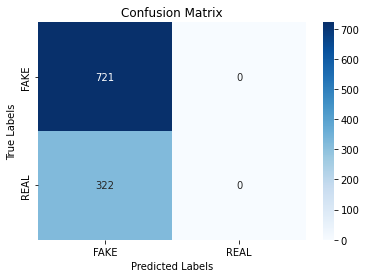

In [ ]:
# model evaluation

print("Doc2Vec, LSTM, undersampling")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

# **Oversampling**

Here we apply oversampling techique - SMOTE - in order to assess the contribution of it on classifier performance

In [ ]:
## CoLA
import pandas as pd

data_pth = '/content/data'
TASKS = ["CoLA", "SST-2", "RTE"]

colnames_train = ['id', 'index', 'field_1', 'sentence']
colnames_test = ['index', 'sentence']
train_data = pd.read_table(os.path.join(data_pth, TASKS[0], 'train.tsv'), names=colnames_train, header=None)
test_data = pd.read_table(os.path.join(data_pth, TASKS[0], 'dev.tsv'), names=colnames_train, header=None)

In [ ]:
test_data

In [ ]:
x_train = train_data.loc[:,'sentence']
y_train = train_data.loc[:,'index']
x_test = test_data.loc[:,'sentence']
y_test = test_data.loc[:,'index']

## **BERT**

In [ ]:
import time
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

stop_words = set(stopwords.words('english'))
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

def sent_preprocess(sentence):
  word_tokens = word_tokenize(sentence)
  filtered_sentence = [w.lower() for w in word_tokens if w not in stop_words]
  
  tokens = {'input_ids': [], 'attention_mask': []}

  new_tokens = tokenizer.encode_plus(sentence, max_length=128,
                                      truncation=True, padding='max_length',
                                      return_tensors='pt')
  tokens['input_ids'].append(new_tokens['input_ids'][0])
  tokens['attention_mask'].append(new_tokens['attention_mask'][0])

  tokens['input_ids'] = torch.stack(tokens['input_ids'])
  tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

  outputs = model(**tokens)
  embeddings = outputs.last_hidden_state

  attention_mask = tokens['attention_mask']
  mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
  masked_embeddings = embeddings * mask
  summed = torch.sum(masked_embeddings, 1)
  summed_mask = torch.clamp(mask.sum(1), min=1e-9)
  mean_pooled = summed / summed_mask

  mean_pooled = mean_pooled.detach().numpy()

  return mean_pooled

In [ ]:
import tqdm

if x_test_preprocessed_bert and x_train_preprocessed_bert:
  x_train_preprocessed = x_train_preprocessed_bert
  x_test_preprocessed = x_test_preprocessed_bert
else:
  x_train_preprocessed = [sent_preprocess(sent) for sent in tqdm.tqdm(x_train)]
  x_test_preprocessed = [sent_preprocess(sent) for sent in tqdm.tqdm(x_test)]

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()

vector_size = 768

x_train_preprocessed, y_train = sm.fit_resample(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed), vector_size]), y_train)

In [ ]:
x_train_preprocessed = x_train_preprocessed.reshape([len(x_train_preprocessed), 1, vector_size])

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np
import pandas as pd

size = np.array(x_train_preprocessed).shape[0]
vector_size = 768

df_train = pd.DataFrame(np.array(x_train_preprocessed).reshape([size,vector_size]))
df_test = pd.DataFrame(np.array(x_test_preprocessed).reshape([np.array(x_test_preprocessed).shape[0],vector_size]))

df_train.to_csv('df_train_CoLA_over.csv')
df_test.to_csv('df_test_CoLA_over.csv')

In [ ]:
print(len(x_train_preprocessed))

12046


In [ ]:
x_valid_preprocessed = x_train_preprocessed[11201:size]
x_train_preprocessed = x_train_preprocessed[0:11200]

y_valid = y_train[11201:size]
y_train = y_train[0:11200]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

### **General Classifiers**

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)

print(models)

100%|██████████| 29/29 [13:36<00:00, 28.16s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LabelSpreading                     1.00               1.00    None      1.00   
LabelPropagation                   1.00               1.00    None      1.00   
XGBClassifier                      0.98               0.98    None      0.99   
QuadraticDiscriminantAnalysis      0.96               0.96    None      0.98   
ExtraTreesClassifier               0.96               0.96    None      0.98   
NuSVC                              0.95               0.95    None      0.98   
KNeighborsClassifier               0.95               0.95    None      0.97   
RandomForestClassifier             0.95               0.95    None      0.97   
LGBMClassifier                     0.94               0.94    None      0.97   
SVC                                0.93               0.93    None      0.96   
BaggingClassifier                  0.92 

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['NuSVC'].predict(np.array(x_test_preprocessed).reshape([x_test.shape[0],vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

736 1043


BERT, best general classifier, oversampling
F-measure or f1-score:  0.7997390737116764
Log loss:  10.16640793204812
AUC:  0.6160978110112767
Classification Report:
              precision    recall  f1-score   support

           1     0.7549    0.8502    0.7997       721
           0     0.5325    0.3820    0.4448       322

    accuracy                         0.7057      1043
   macro avg     0.6437    0.6161    0.6223      1043
weighted avg     0.6862    0.7057    0.6902      1043



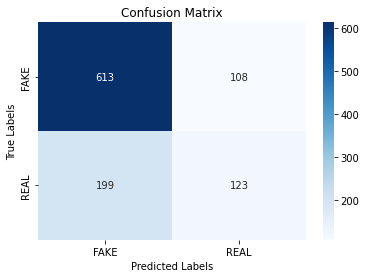

In [ ]:
# model evaluation

print("BERT, best general classifier, oversampling")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

### **LSTM classifier**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed), y_train, validation_data=(np.array(x_valid_preprocessed), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
88/88 [==============================] - 33s 313ms/step - loss: 0.6548 - val_loss: 0.6640
Epoch 2/50
88/88 [==============================] - 19s 211ms/step - loss: 0.5750 - val_loss: 0.5389
Epoch 3/50
88/88 [==============================] - 18s 200ms/step - loss: 0.5031 - val_loss: 0.5935
Epoch 4/50
88/88 [==============================] - 18s 200ms/step - loss: 0.4459 - val_loss: 0.2842
Epoch 5/50
88/88 [==============================] - 18s 201ms/step - loss: 0.3952 - val_loss: 0.3078
Epoch 6/50
88/88 [==============================] - 17s 199ms/step - loss: 0.3449 - val_loss: 0.2824
Epoch 7/50
88/88 [==============================] - 17s 198ms/step - loss: 0.3019 - val_loss: 0.1533
Epoch 8/50
88/88 [==============================] - 18s 210ms/step - loss: 0.2671 - val_loss: 0.1740
Epoch 9/50
88/88 [==============================] - 18s 199ms/step - loss: 0.2380 - val_loss: 0.1476
Epoch 10/50
88/88 [==============================] - 18s 200ms/step - loss: 0.2096 - val_lo

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

721 1043


BERT, LSTM, oversampling
F-measure or f1-score:  0.8174603174603174
Log loss:  nan
Log loss:  10.663224803004567
AUC:  0.6805011156003136
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.6913    1.0000    0.8175       721
           0     0.0000    0.0000    0.0000       322

    accuracy                         0.6913      1043
   macro avg     0.3456    0.5000    0.4087      1043
weighted avg     0.4779    0.6913    0.5651      1043



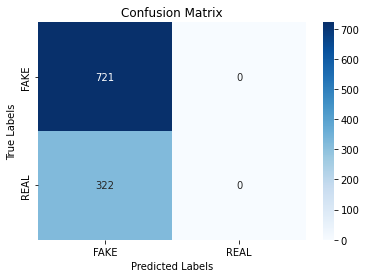

In [ ]:
# model evaluation

print("BERT, LSTM, oversampling")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

## **Doc2Vec**

In [ ]:
!pip install --upgrade numpy

In [ ]:
tagged_train_sent = sent_tokenize(x_train)
tagged_test_sent = sent_tokenize(x_test)

In [ ]:
tagged_train_sent

In [ ]:
vector_size = 100

model_doc2vec = Doc2Vec(tagged_train_sent+tagged_test_sent, vector_size = vector_size, window = 4, min_count = 1, epochs = 100)

In [ ]:
import tqdm

if x_test_preprocessed_doc2vec and x_train_preprocessed_doc2vec:
  x_test_preprocessed = x_test_preprocessed_doc2vec
  x_train_preprocessed = x_train_preprocessed_doc2vec
else:
  x_train_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_train)]
  x_test_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_test)]

In [ ]:
x_train = train_data.loc[:,'sentence']
y_train = train_data.loc[:,'index']
x_test = test_data.loc[:,'sentence']
y_test = test_data.loc[:,'index']

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()

x_train_preprocessed, y_train = sm.fit_resample(x_train_preprocessed, y_train)

In [ ]:
import numpy as np

np.array(x_train_preprocessed).shape

(12046, 100)

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np
import pandas as pd

size = np.array(x_train_preprocessed).shape[0]

vector_size = 100

df_train = pd.DataFrame(np.array(x_train_preprocessed).reshape([size,vector_size]))
df_test = pd.DataFrame(np.array(x_test_preprocessed).reshape([np.array(x_test_preprocessed).shape[0],vector_size]))

df_train.to_csv('df_train_doc2vec_100_CoLA_under.csv')
df_test.to_csv('df_test_doc2vec_100_CoLA_under.csv')

In [ ]:
x_valid_preprocessed = x_train_preprocessed[11201:size]
x_train_preprocessed = x_train_preprocessed[0:11200]

y_valid = y_train[11201:size]
y_train = y_train[0:11200]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

845
11200
845
11200


### **General classifier**

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)

print(models)

100%|██████████| 29/29 [02:42<00:00,  5.61s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LabelPropagation                   1.00               1.00    None      1.00   
LabelSpreading                     1.00               1.00    None      1.00   
NuSVC                              0.95               0.95    None      0.98   
ExtraTreesClassifier               0.92               0.92    None      0.96   
KNeighborsClassifier               0.91               0.91    None      0.95   
RandomForestClassifier             0.88               0.88    None      0.94   
BaggingClassifier                  0.87               0.87    None      0.93   
XGBClassifier                      0.87               0.87    None      0.93   
QuadraticDiscriminantAnalysis      0.86               0.86    None      0.93   
SVC                                0.86               0.86    None      0.93   
LGBMClassifier                     0.84 

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['ExtraTreesClassifier'].predict(np.array(x_test_preprocessed).reshape([x_test.shape[0],vector_size]))

print(sum([predictions[i] == y_test[i] for i in range(len(x_test))]), len(x_test))

679 1043


Doc2vec, best general classifier, oversampling
F-measure or f1-score:  0.7801932367149758
Log loss:  12.05402271467384
AUC:  0.4992311403244286
Classification Report:
              precision    recall  f1-score   support

           1     0.6909    0.8960    0.7802       721
           0     0.3056    0.1025    0.1535       322

    accuracy                         0.6510      1043
   macro avg     0.4982    0.4992    0.4668      1043
weighted avg     0.5719    0.6510    0.5867      1043



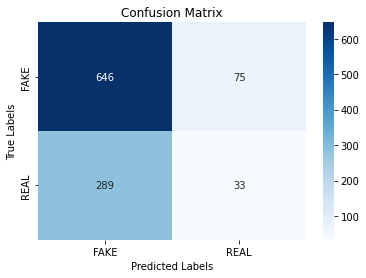

In [ ]:
# model evaluation

print("Doc2vec, best general classifier, oversampling")
print("F-measure or f1-score: ", f1_score(y_test, predictions))
print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_test, predictions)

### **LSTM classifier**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
88/88 [==============================] - 22s 189ms/step - loss: 0.6856 - val_loss: 0.8700
Epoch 2/50
88/88 [==============================] - 18s 201ms/step - loss: 0.6786 - val_loss: 0.7829
Epoch 3/50
88/88 [==============================] - 12s 133ms/step - loss: 0.6748 - val_loss: 0.7150
Epoch 4/50
88/88 [==============================] - 12s 132ms/step - loss: 0.6689 - val_loss: 0.7743
Epoch 5/50
88/88 [==============================] - 12s 132ms/step - loss: 0.6610 - val_loss: 0.7383
Epoch 6/50
88/88 [==============================] - 12s 133ms/step - loss: 0.6511 - val_loss: 0.6568
Epoch 7/50
88/88 [==============================] - 12s 132ms/step - loss: 0.6425 - val_loss: 0.6070
Epoch 8/50
88/88 [==============================] - 12s 131ms/step - loss: 0.6362 - val_loss: 0.6898
Epoch 9/50
88/88 [==============================] - 12s 131ms/step - loss: 0.6303 - val_loss: 0.6257
Epoch 10/50
88/88 [==============================] - 12s 135ms/step - loss: 0.6256 - val_lo

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == y_test[i] for i in range(len(x_test))]), len(x_test))

721 1043


Doc2Vec, LSTM, oversampling
F-measure or f1-score:  0.8174603174603174
Log loss:  0.7466806529426623
Log loss:  10.663224803004567
AUC:  0.574874441123009
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.6913    1.0000    0.8175       721
           0     0.0000    0.0000    0.0000       322

    accuracy                         0.6913      1043
   macro avg     0.3456    0.5000    0.4087      1043
weighted avg     0.4779    0.6913    0.5651      1043



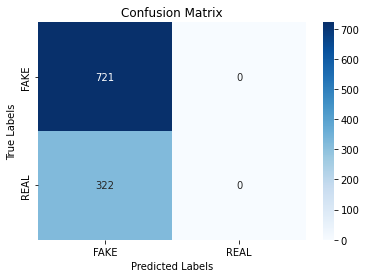

In [ ]:
# model evaluation

print("Doc2Vec, LSTM, oversampling")
print("F-measure or f1-score: ", f1_score(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_test, predictions_lstm))
print("Log loss: ", log_loss(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_test, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_test,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_test, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])